# Example 06: Custom Normalization

Neural networks train faster when inputs are properly scaled. TSFast
normalizes inputs by default using z-score normalization. This example shows
all built-in scalers, compares their effects on training, and demonstrates
how to create a custom scaler.

## Prerequisites

- [Example 00: Your First Model](00_your_first_model.ipynb)
- [Example 01: Understanding the Data Pipeline](01_data_pipeline.ipynb)

## Setup

In [1]:
import torch

from tsfast.datasets.benchmark import create_dls_silverbox
from tsfast.models.rnn import RNNLearner
from tsfast.models.layers import Scaler, StandardScaler1D, MinMaxScaler1D, MaxAbsScaler1D
from tsfast.learner.losses import fun_rmse

## Why Normalization Matters

Neural networks learn best when input features are on similar scales. Without
normalization, features with large magnitudes dominate gradient updates,
causing slow or unstable training. TSFast automatically normalizes input
signals by default.

## Load the Dataset

In [2]:
dls = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)

## Built-in Scalers

TSFast provides three built-in scalers:

- **`StandardScaler1D`** (default): z-score normalization.
  `x_norm = (x - mean) / std`
- **`MinMaxScaler1D`**: scales to [0, 1].
  `x_norm = (x - min) / (max - min)`
- **`MaxAbsScaler1D`**: scales to [-1, 1].
  `x_norm = x / max(|min|, |max|)`

## Training with Different Scalers

Train with each scaler for a fair comparison. All models use the same
architecture and training schedule so the only difference is the scaler.

In [3]:
lrn_std = RNNLearner(dls, rnn_type='lstm', metrics=[fun_rmse])
lrn_std.fit_flat_cos(n_epoch=5, lr=3e-3)
print(f"StandardScaler1D: {lrn_std.validate()}")

epoch,train_loss,valid_loss,fun_rmse,time
0,0.007377,0.004649,0.010185,00:03
1,0.005237,0.004806,0.009962,00:03
2,0.005130,0.003341,0.009520,00:03
3,0.004921,0.004300,0.009729,00:03
4,0.002927,0.002943,0.009481,00:03


StandardScaler1D: [0.002942795166745782, 0.0094813397154212]


In [4]:
lrn_mm = RNNLearner(dls, rnn_type='lstm', input_norm=MinMaxScaler1D, metrics=[fun_rmse])
lrn_mm.fit_flat_cos(n_epoch=5, lr=3e-3)
print(f"MinMaxScaler1D:   {lrn_mm.validate()}")

epoch,train_loss,valid_loss,fun_rmse,time
0,0.007927,0.006600,0.011538,00:03
1,0.006934,0.006080,0.011311,00:03
2,0.006203,0.005964,0.010715,00:04
3,0.005118,0.005527,0.010327,00:04
4,0.003113,0.003119,0.009490,00:04


MinMaxScaler1D:   [0.003119391156360507, 0.009490455500781536]


In [5]:
lrn_ma = RNNLearner(dls, rnn_type='lstm', input_norm=MaxAbsScaler1D, metrics=[fun_rmse])
lrn_ma.fit_flat_cos(n_epoch=5, lr=3e-3)
print(f"MaxAbsScaler1D:   {lrn_ma.validate()}")

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006911,0.006106,0.011410,00:04
1,0.004676,0.004263,0.009811,00:04
2,0.005675,0.005097,0.010239,00:04
3,0.004513,0.003927,0.009701,00:04
4,0.002977,0.003117,0.009527,00:05


MaxAbsScaler1D:   [0.0031167706474661827, 0.009527360089123249]


In [6]:
lrn_none = RNNLearner(dls, rnn_type='lstm', input_norm=None, metrics=[fun_rmse])
lrn_none.fit_flat_cos(n_epoch=5, lr=3e-3)
print(f"No normalization: {lrn_none.validate()}")

epoch,train_loss,valid_loss,fun_rmse,time
0,0.007681,0.006412,0.011398,00:03
1,0.006629,0.006266,0.011650,00:03
2,0.006600,0.006007,0.011304,00:03
3,0.006471,0.006596,0.011801,00:03
4,0.005893,0.005741,0.011229,00:03


No normalization: [0.005741341970860958, 0.011229108087718487]


## Output Normalization

By default, only inputs are normalized and outputs stay in physical units.
For multi-output systems where outputs have very different scales, you can
also normalize outputs. Predictions are automatically denormalized back to
physical units.

In [7]:
lrn_out = RNNLearner(dls, rnn_type='lstm', output_norm=StandardScaler1D, metrics=[fun_rmse])
lrn_out.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006183,0.007185,0.011697,00:03
1,0.005300,0.003294,0.009624,00:04
2,0.004902,0.005333,0.010250,00:04
3,0.005190,0.005127,0.010154,00:03
4,0.002986,0.003008,0.009563,00:03


## Creating a Custom Scaler

To create a custom scaler, subclass `Scaler` and implement three methods:
`normalize`, `denormalize`, and the `from_stats` classmethod. Here is an
example that clips values to a fixed range and then scales to [-1, 1].

In [8]:
class ClipScaler(Scaler):
    """Clips values to [-clip_val, clip_val] then scales to [-1, 1]."""

    def __init__(self, clip_val: torch.Tensor):
        super().__init__()
        self.register_buffer('clip_val', clip_val)

    def normalize(self, x: torch.Tensor) -> torch.Tensor:
        return torch.clamp(x, -self.clip_val, self.clip_val) / self.clip_val

    def denormalize(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.clip_val

    @classmethod
    def from_stats(cls, stats):
        clip_val = torch.max(torch.abs(torch.tensor(stats.min)),
                             torch.abs(torch.tensor(stats.max))).float()
        return cls(clip_val.unsqueeze(0).unsqueeze(0))

`from_stats` receives a `NormPair` object containing the dataset statistics
(`mean`, `std`, `min`, `max` as 1-D arrays) and must return a configured
scaler instance. `register_buffer` ensures the parameters move with the
model to GPU/CPU automatically.

Train with the custom scaler:

In [9]:
lrn_custom = RNNLearner(dls, rnn_type='lstm', input_norm=ClipScaler, metrics=[fun_rmse])
lrn_custom.fit_flat_cos(n_epoch=5, lr=3e-3)
print(f"ClipScaler:       {lrn_custom.validate()}")

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006961,0.006427,0.011529,00:03
1,0.006368,0.006009,0.010919,00:03
2,0.005262,0.005950,0.010636,00:03
3,0.005056,0.004367,0.009818,00:03
4,0.003041,0.003081,0.009558,00:03


ClipScaler:       [0.003081083996221423, 0.009557779878377914]


## Visualize Results

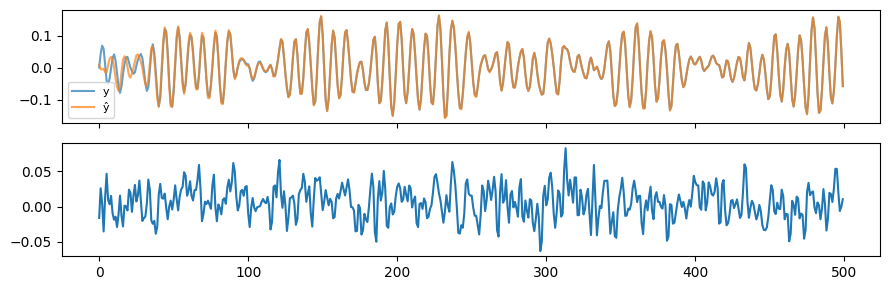

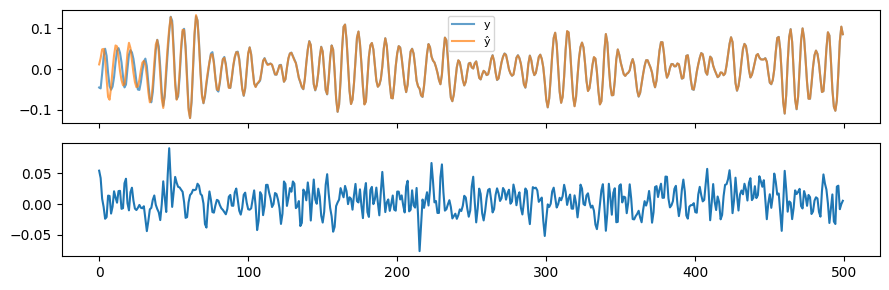

In [10]:
lrn_custom.show_results(max_n=2)

## Key Takeaways

- **`StandardScaler1D`** (z-score) is the default and works well for most
  problems.
- **`MinMaxScaler1D`** and **`MaxAbsScaler1D`** are alternatives for bounded
  signals.
- **`input_norm=None`** disables normalization (useful for pre-normalized
  data).
- **`output_norm=StandardScaler1D`** normalizes outputs for multi-scale
  training. Predictions are automatically denormalized.
- Custom scalers subclass `Scaler` with `normalize`, `denormalize`, and
  `from_stats`.